# Notebook 2: Minimal Transformer Encoder Block

In [1]:
# Imports and config
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import datasets, transforms

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)

HIDDEN_DIM = 128
INTERMEDIATE_DIM = 256
NUM_HEADS = 4


### Transformers

At its heart, a **Transformer** is a neural network that processes sequences (like text, proteins, small molecules) by repeatedly mixing information across tokens. It does so using two fundamental operations:

1. **Self-Attention:**
    
    This mechanism lets every token “look at” (or attend to) every other token in the sequence, measuring their similarity to decide how much information to gather from each. It’s like having each word in a sentence ask, “Which other words are most relevant to me?”
    
2. **Multi-Layer Perceptron (MLP):**
    
    After the attention has mixed the information, an MLP (a simple feed-forward network) processes each token independently to add non-linear transformations. This helps the model capture complex patterns and higher-level abstractions.
    

So we let the portions of the input talk to each other with attention, and we modify the inputs themselves with the MLP.

In a Transformer layer (or “block”), these two operations are typically arranged in sequentially (with additional normalization and residual connections, which we won’t detail here for simplicity). A full transformers is just a bunch of these blocks stacked together sequentially. For context, GPT3 is 96 blocks and ESM2 (650M) is 33 blocks.

### First, let's implement attention manually.

Recall, that

Self-attention is a way for the model to compute relationships between tokens. It works by transforming the input tokens into three sets of vectors:

- **Queries (Q)**
- **Keys (K)**
- **Values (V)**

The idea is to measure how similar the query of one token is to the keys of all tokens. These similarities then determine how much each token’s value should contribute to the updated representation.

#### The Math Behind It

For a set of token embeddings organized as a matrix $X \in \mathbb{R}^{l \times d}$ (with $l$  tokens and embedding dimension $d$), we project $X$ into $Q$, $K$, and $V$ using learned weight matrices:

$Q = XW_Q,\quad K = XW_K,\quad V = XW_V$,

where an input of L tokens makes $X \in \mathbb{R}^{l \times d}$ and the weights are $\mathbb{R}^{d \times d}$

The self-attention output is computed as:

$\text{Attention}(Q, K, V) = \text{softmax}\!\left(\frac{QK^\top}{\sqrt{d_k}}\right) V.$

Here, $d_k$ is the dimensionality of the query/key space (often $d_k = d / h$ when using $h$ attention heads), and the scaling factor $\sqrt{d_k}$ prevents the dot products from growing too large.

In [2]:
# Barebones Python implementation of (single-head) scaled dot-product attention
# No numpy/torch; just lists and math for clarity
import math


def softmax(xs):
    m = max(xs)
    exps = [math.exp(x - m) for x in xs]
    s = sum(exps)
    return [e / s for e in exps]


def transpose(M):
    return [list(col) for col in zip(*M)]


def matmul(A, B):
    # A: n x m, B: m x p → C: n x p
    return [[sum(a * b for a, b in zip(row, col)) for col in zip(*B)] for row in A]


def attention(Q, K, V):
    # Q: (Lq, d), K: (Lk, d), V: (Lk, dv)
    d_k = len(K[0])
    scores = matmul(Q, transpose(K))                      # (Lq, Lk)
    scaled = [[s / math.sqrt(d_k) for s in row] for row in scores]
    weights = [softmax(row) for row in scaled]            # (Lq, Lk)
    O = matmul(weights, V)                                # (Lq, dv)
    return O, weights


# Tiny example with identity projections (Q=K=V=X)
X = [
    [1.0, 0.0, 1.0],  # token 0
    [0.0, 2.0, 0.0],  # token 1
]
O, W = attention(X, X, X)
print('Attention weights (Lq x Lk):')
for row in W:
    print([round(v, 3) for v in row])
print('Output (Lq x d):')
for row in O:
    print([round(v, 3) for v in row])


Attention weights (Lq x Lk):
[0.76, 0.24]
[0.09, 0.91]
Output (Lq x d):
[0.76, 0.479, 0.76]
[0.09, 1.819, 0.09]


In [3]:
# Barebones PyTorch (single-head) scaled dot-product attention
import math
import torch
import torch.nn as nn
import torch.nn.functional as F


class SimpleAttention(nn.Module):
    def forward(self, Q: torch.Tensor, K: torch.Tensor, V: torch.Tensor):
        # Q: (Lq, d), K: (Lk, d), V: (Lk, dv)
        d_k = Q.size(-1)
        scores = Q @ K.t() / math.sqrt(d_k)   # (Lq, Lk)
        weights = F.softmax(scores, dim=-1)   # (Lq, Lk)
        O = weights @ V                       # (Lq, dv)
        return O, weights


# Tiny example mirroring the pure-Python demo (Q=K=V=X)
X = torch.tensor([
    [1.0, 0.0, 1.0],  # token 0
    [0.0, 2.0, 0.0],  # token 1
], dtype=torch.float32)

attn = SimpleAttention()
O, W = attn(X, X, X)
print('Torch attention weights (Lq x Lk):')
for row in W.tolist():
    print([round(v, 3) for v in row])
print('Torch output (Lq x d):')
for row in O.tolist():
    print([round(v, 3) for v in row])


Torch attention weights (Lq x Lk):
[0.76, 0.24]
[0.09, 0.91]
Torch output (Lq x d):
[0.76, 0.479, 0.76]
[0.09, 1.819, 0.09]


In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_dim: int, num_heads: int):
        super().__init__()
        assert hidden_dim % num_heads == 0, "hidden_dim must be divisible by num_heads"
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.head_dim = hidden_dim // num_heads

        self.W_Q = nn.Linear(hidden_dim, hidden_dim)
        self.W_K = nn.Linear(hidden_dim, hidden_dim)
        self.W_V = nn.Linear(hidden_dim, hidden_dim)
        self.W_O = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (batch, length, hidden_dim)
        batch_size, length, hidden_dim = x.size()

        # # (b, h, l, d_h)
        Q = self.W_Q(x) # (b, l, d)
        Q = Q.reshape(batch_size, length, self.num_heads, self.head_dim) # (b, l, n, h)
        Q = Q.transpose(1, 2) # (b, n, l, h)

        K = self.W_K(x) # (b, l, d)
        K = K.reshape(batch_size, length, self.num_heads, self.head_dim) # (b, l, n, h)
        K = K.transpose(1, 2) # (b, n, l, h)
        
        V = self.W_V(x) # (b, l, d)
        V = V.reshape(batch_size, length, self.num_heads, self.head_dim) # (b, l, n, h)
        V = V.transpose(1, 2) # (b, n, l, h)

        K = K.transpose(-1, -2) # (b, n, h, l)

        A = Q @ K / math.sqrt(self.head_dim) # (b, n, l, l)
        A = A.softmax(dim=-1)

        O = A @ V # (b, n, l, h)
        O = O.transpose(1, 2) # (b, l, n, h)
        O = O.reshape(batch_size, length, self.hidden_dim) # (b, l, d)
        return self.W_O(O)


In [ ]:
class MLP(nn.Module):
    def __init__(self, hidden_dim: int, intermediate_dim: int):
        super().__init__()
        self.w1 = nn.Linear(hidden_dim, intermediate_dim)
        self.w2 = nn.Linear(intermediate_dim, hidden_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.w2(F.relu(self.w1(x)))


In [4]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, hidden_dim: int, intermediate_dim: int, num_heads: int):
        super().__init__()
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.mha = MultiHeadAttention(hidden_dim, num_heads)
        self.ln2 = nn.LayerNorm(hidden_dim)
        self.mlp = MLP(hidden_dim, intermediate_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Pre-norm
        h = x + self.mha(self.ln1(x))
        h = h + self.mlp(self.ln2(h))
        return h


In [5]:
# Synthetic data forward pass
batch, length = 4, 32
x = torch.randn(batch, length, HIDDEN_DIM)
block = TransformerEncoderBlock(HIDDEN_DIM, INTERMEDIATE_DIM, NUM_HEADS)
y = block(x)
print('Input:', x.shape, 'Output:', y.shape)


Input: torch.Size([4, 32, 128]) Output: torch.Size([4, 32, 128])


## Intuition and design choices
- Pre-norm improves optimization stability for deeper stacks.
- LayerNorm normalizes features per token; residuals preserve information flow.
- Multi-Head splits the space to attend to different patterns in parallel.
- MLP expands features nonlinearly.


### Sinusoidal vs Rotary positional encodings

- **Sinusoidal (absolute)**: Add a position-dependent vector directly to token embeddings: `x_pos = x + PE[pos]`. Attention then mixes content and absolute positions via dot-products. Pros: no learned parameters, extrapolates to longer lengths due to periodic closed-form. Cons: encodes absolute position; relative comparisons are indirect.
- **Rotary (relative via rotation of Q/K)**: Apply a position-dependent rotation to query/key dimensions before attention: `Q' = RoPE(Q, pos)`, `K' = RoPE(K, pos)`. This makes the attention score depend on position differences (relative), improving length extrapolation and preserving content/value paths (V is untouched). No need to modify token embeddings.

Below we compare attention patterns produced by a small attention layer with (1) sinusoidal added to inputs and (2) rotary applied inside attention (from `transformer.py`).


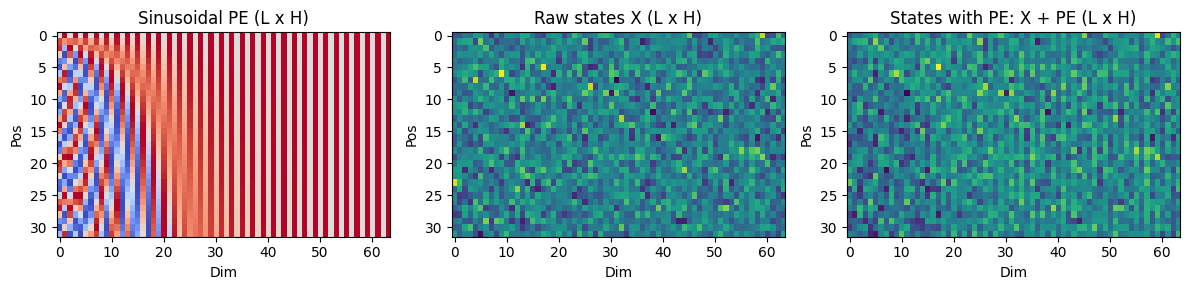

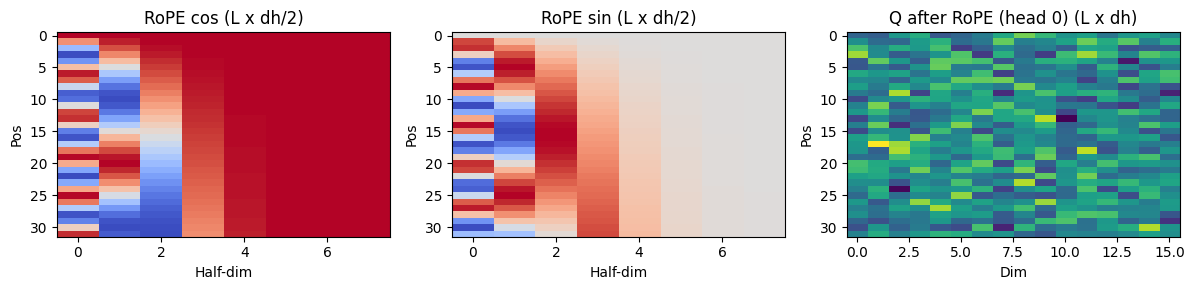

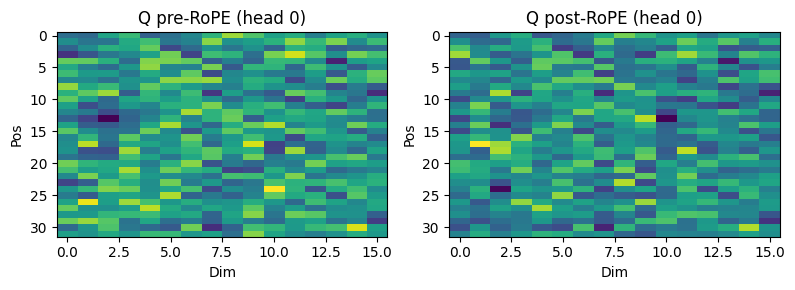

In [7]:
# Visualize positional components and resulting states (Sinusoidal vs Rotary)
import math
import torch
import matplotlib.pyplot as plt
from transformer import MultiHeadAttention


def sinusoidal_position_encoding(length: int, dim: int) -> torch.Tensor:
    pos = torch.arange(length).unsqueeze(1)           # (L,1)
    i = torch.arange(dim).unsqueeze(0)                # (1,d)
    angle_rates = 1 / torch.pow(10000, (2*(i//2))/dim)
    angles = pos * angle_rates                        # (L,d)
    pe = torch.zeros(length, dim)
    pe[:, 0::2] = torch.sin(angles[:, 0::2])
    pe[:, 1::2] = torch.cos(angles[:, 1::2])
    return pe


# Setup
# Assumes SEED is defined in the imports/config cell
torch.manual_seed(SEED)
B, L, H, HEADS = 1, 32, 64, 4
x = torch.randn(B, L, H)

# --- Sinusoidal (absolute) ---
pe = sinusoidal_position_encoding(L, H)               # (L, H)
x_abs = x.clone()
x_abs_pe = x_abs + pe.unsqueeze(0)                    # (B, L, H)

# Visualize PE, raw states, and states with PE
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
axes[0].imshow(pe.numpy(), cmap='coolwarm', aspect='auto')
axes[0].set_title('Sinusoidal PE (L x H)')
axes[0].set_xlabel('Dim')
axes[0].set_ylabel('Pos')

axes[1].imshow(x_abs[0].numpy(), cmap='viridis', aspect='auto')
axes[1].set_title('Raw states X (L x H)')
axes[1].set_xlabel('Dim')
axes[1].set_ylabel('Pos')

axes[2].imshow(x_abs_pe[0].numpy(), cmap='viridis', aspect='auto')
axes[2].set_title('States with PE: X + PE (L x H)')
axes[2].set_xlabel('Dim')
axes[2].set_ylabel('Pos')
plt.tight_layout()
plt.show()

# --- Rotary (relative) ---
attn_rope = MultiHeadAttention(hidden_size=H, n_heads=HEADS, rotary=True, causal=False)
# Build Q,K pre-rotation
qkv = attn_rope.layernorm_qkv(x)
q, k, v = torch.chunk(qkv, 3, dim=-1)
q, k = attn_rope.q_ln(q).to(q.dtype), attn_rope.k_ln(k).to(k.dtype)
# Shape to (B, L, Hh, Dh)
hh, dh = attn_rope.n_heads, attn_rope.d_head
q_pre = q.view(B, L, hh, dh)
k_pre = k.view(B, L, hh, dh)
# Apply rotary to get post-rotation Q,K
q_post, k_post = attn_rope.rotary(q_pre.clone(), k_pre.clone())

# Access RoPE cos/sin caches (L, dh/2)
cos = attn_rope.rotary._cos_cached.detach().cpu() if attn_rope.rotary._cos_cached is not None else None
sin = attn_rope.rotary._sin_cached.detach().cpu() if attn_rope.rotary._sin_cached is not None else None

# Pick a head to visualize
head = 0
q_pre_h = q_pre[0, :, head, :].detach().cpu()    # (L, dh)
q_post_h = q_post[0, :, head, :].detach().cpu()  # (L, dh)

# Visualize RoPE components and Q before/after rotation
cols = 3
fig, axes = plt.subplots(1, cols, figsize=(12, 3))
axes[0].imshow(cos.numpy(), cmap='coolwarm', aspect='auto')
axes[0].set_title('RoPE cos (L x dh/2)')
axes[0].set_xlabel('Half-dim')
axes[0].set_ylabel('Pos')

axes[1].imshow(sin.numpy(), cmap='coolwarm', aspect='auto')
axes[1].set_title('RoPE sin (L x dh/2)')
axes[1].set_xlabel('Half-dim')
axes[1].set_ylabel('Pos')

axes[2].imshow(q_post_h.numpy(), cmap='viridis', aspect='auto')
axes[2].set_title('Q after RoPE (head 0) (L x dh)')
axes[2].set_xlabel('Dim')
axes[2].set_ylabel('Pos')
plt.tight_layout()
plt.show()

# Optional: side-by-side Q pre vs post for the same head
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].imshow(q_pre_h.numpy(), cmap='viridis', aspect='auto')
axes[0].set_title('Q pre-RoPE (head 0)')
axes[0].set_xlabel('Dim')
axes[0].set_ylabel('Pos')
axes[1].imshow(q_post_h.numpy(), cmap='viridis', aspect='auto')
axes[1].set_title('Q post-RoPE (head 0)')
axes[1].set_xlabel('Dim')
axes[1].set_ylabel('Pos')
plt.tight_layout()
plt.show()
